### Imports

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

import warnings
warnings.filterwarnings("ignore")

### Load data from files

In [9]:
# Load Random Search results from best_models_summary.csv
rs_best_models = pd.read_csv('RandomForestData/best_models_summary.csv')

# Extract baseline brier scores (these are from RandomForest.ipynb baseline runs)
baseline_brier_scores = [0.1892, 0.1819, 0.1067, 0.1520]  # Bank, Gym, Heart Disease, Titanic

# Extract Random Search best parameters and test scores for each dataset
import ast

random_brier_adj = []
random_best_params = []

for dataset_name in ['Bank', 'Gym', 'Heart Disease', 'Titanic']:
    row = rs_best_models[rs_best_models['dataset'] == dataset_name].iloc[0]
    random_brier_adj.append(row['brier_score'])
    random_best_params.append(ast.literal_eval(row['params']))

print("Random Search - Loaded from files:")
for ds, brier in zip(['Bank', 'Gym', 'Heart Disease', 'Titanic'], random_brier_adj):
    print(f"  {ds}: {brier}")

Random Search - Loaded from files:
  Bank: 0.1858421833675464
  Gym: 0.1534136800030513
  Heart Disease: 0.1277791441181989
  Titanic: 0.1104537560930364


In [10]:
# Load Bayesian Optimization results from all_bayesian_results.csv
bayes_results = pd.read_csv('RandomForestData/all_bayesian_results.csv')

# Extract Bayesian best parameters and test scores for each dataset
bayes_brier_adj = []
bayes_best_params = []

for dataset_name in ['Bank', 'Gym', 'Heart Disease', 'Titanic']:
    # Filter for this dataset and completed trials
    ds_trials = bayes_results[bayes_results['dataset'] == dataset_name]
    ds_completed = ds_trials[ds_trials['state'] == 1]  # State 1 = COMPLETE
    
    # Get best trial (lowest brier_score)
    best_trial = ds_completed.loc[ds_completed['brier_score'].idxmin()]
    
    # Extract test brier score (unique per dataset)
    bayes_brier_adj.append(best_trial['test_brier_score'])
    
    # Extract parameters
    params = {
        'n_estimators': int(best_trial['n_estimators']),
        'criterion': best_trial['criterion'],
        'max_depth': None if pd.isna(best_trial['max_depth']) else int(best_trial['max_depth']),
        'min_samples_split': int(best_trial['min_samples_split']),
        'min_samples_leaf': int(best_trial['min_samples_leaf']),
        'max_features': best_trial['max_features'] if best_trial['max_features'] == 'sqrt' else float(best_trial['max_features']),
        'max_samples': None if pd.isna(best_trial['max_samples']) else float(best_trial['max_samples'])
    }
    bayes_best_params.append(params)

print("\nBayesian Optimization - Loaded from files:")
for ds, brier in zip(['Bank', 'Gym', 'Heart Disease', 'Titanic'], bayes_brier_adj):
    print(f"  {ds}: {brier}")


Bayesian Optimization - Loaded from files:
  Bank: 0.1843225378562384
  Gym: 0.1786213871377209
  Heart Disease: 0.1044106469027575
  Titanic: 0.1520592793866828


In [11]:
# Load subset comparison results from subset_comparison_results.csv
subset_results = pd.read_csv('RandomForestData/subset_comparison_results.csv')

# Filter for Random Search method (we'll use Random Search subset data)
rs_subsets = subset_results[subset_results['method'] == 'Random Search'].sort_values('frac')

subset_fracs = list(rs_subsets['frac'])
subset_brier_cv = list(rs_subsets['brier_cv'])
subset_brier_test = list(rs_subsets['brier_test'])

# For subset best_params, we'll use the same best params from Random Search
# (the subset analysis used the same parameters across different data fractions)
subset_best_params = [random_best_params[0]] * 4  # Using Bank dataset params

print("\nSubset analysis - Loaded from files:")
for frac, brier in zip(subset_fracs, subset_brier_test):
    print(f"  {int(frac*100)}%: {brier}")


Subset analysis - Loaded from files:
  25%: 0.1943605030715737
  50%: 0.1927654512941477
  75%: 0.1923118257053812
  100%: 0.1858421833675464


### Create data dictionaries from loaded values

In [12]:
# Create random dict from loaded data
random = {
    'dataset': ['bank', 'gym', 'heart', 'titanic'],
    'brier_adj': random_brier_adj,
    'baseline_brier': baseline_brier_scores,
    'best_params': random_best_params
}

print("\nRandom Search dict created from files:")
print(f"  Datasets: {random['dataset']}")
print(f"  Brier scores: {random['brier_adj']}")


Random Search dict created from files:
  Datasets: ['bank', 'gym', 'heart', 'titanic']
  Brier scores: [np.float64(0.1858421833675464), np.float64(0.1534136800030513), np.float64(0.1277791441181989), np.float64(0.1104537560930364)]


In [13]:
# Create bayes dict from loaded data
bayes = {
    'dataset': ['bank', 'gym', 'heart', 'titanic'],
    'brier_adj': bayes_brier_adj,
    'baseline_brier': baseline_brier_scores,
    'best_params': bayes_best_params
}

print("\nBayesian Optimization dict created from files:")
print(f"  Datasets: {bayes['dataset']}")
print(f"  Brier scores: {bayes['brier_adj']}")


Bayesian Optimization dict created from files:
  Datasets: ['bank', 'gym', 'heart', 'titanic']
  Brier scores: [np.float64(0.1843225378562384), np.float64(0.1786213871377209), np.float64(0.1044106469027575), np.float64(0.1520592793866828)]


In [14]:
# Create subsets dict from loaded data
subsets = {
    'frac': subset_fracs,
    'brier_cv': subset_brier_cv,
    'brier_test': subset_brier_test,
    'best_params': subset_best_params
}

print("\nSubsets dict created from files:")
print(f"  Fractions: {subsets['frac']}")
print(f"  Brier test scores: {subsets['brier_test']}")


Subsets dict created from files:
  Fractions: [0.25, 0.5, 0.75, 1.0]
  Brier test scores: [0.1943605030715737, 0.1927654512941477, 0.1923118257053812, 0.1858421833675464]


### Approach for establishing best hyperparameter set for RandomForest:
1. Choose better brier score out of two hyperparameter tuning methods for each dataset
2. Calculate median of hyperparameter values among chosen using criterium above

In [15]:
bayes_df = pd.DataFrame(bayes)
random_df = pd.DataFrame(random)
subsets_df = pd.DataFrame(subsets)

In [16]:
subsets_df

,frac,brier_cv,brier_test,best_params
0,0.25,0.191727,0.194361,"{'criterion': 'entropy', 'max_depth': None, 'm..."
1,0.50,0.187018,0.192765,"{'criterion': 'entropy', 'max_depth': None, 'm..."
2,0.75,0.185161,0.192312,"{'criterion': 'entropy', 'max_depth': None, 'm..."
3,1.00,0.185842,0.185842,"{'criterion': 'entropy', 'max_depth': None, 'm..."


In [17]:
bayes_df.columns

Index(['dataset', 'brier_adj', 'baseline_brier', 'best_params'], dtype='object')

In [18]:
best_params = np.where(
    bayes_df['brier_adj'] < random_df['brier_adj'],
    bayes_df['best_params'],
    random_df['best_params']
)

In [19]:
best_params

array([{'n_estimators': 1375, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 0.25, 'max_samples': 0.9},
       {'criterion': 'log_loss', 'max_depth': None, 'max_features': 0.33, 'max_samples': None, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 1319},
       {'n_estimators': 1449, 'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.25, 'max_samples': 0.9},
       {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 996}],
      dtype=object)

In [20]:
best_params_list = list(best_params)

In [21]:
median_params = pd.DataFrame(best_params_list).median(numeric_only=True).to_dict()

In [22]:
int_params = ['max_depth', 'min_samples_leaf', 'n_estimators', 'min_samples_split']

for param in int_params:
    if param in median_params:
        median_params[param] = int(round(median_params[param]))

print(median_params)

{'n_estimators': 1347, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_samples': 0.9}


#### Preparing data to check result of analysis

In [23]:
X1 = pd.read_csv("preprocessed_datasets/bank_data.csv")
y1 = pd.read_csv("preprocessed_datasets/bank_target.csv").squeeze()
X2 = pd.read_csv("preprocessed_datasets/gym_data.csv")
y2 = pd.read_csv("preprocessed_datasets/gym_target.csv").squeeze()
X3 = pd.read_csv("preprocessed_datasets/heartDisease_data.csv")
y3 = pd.read_csv("preprocessed_datasets/heartDisease_target.csv").squeeze()
X4 = pd.read_csv("preprocessed_datasets/titanic_data.csv")
y4 = pd.read_csv("preprocessed_datasets/titanic_target.csv").squeeze()

In [24]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=y3)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42, stratify=y4)

#### Training model on new hyperparameters and comparing with default set

In [25]:
datasets = [(X1_train, X1_test, y1_train, y1_test),
            (X2_train, X2_test, y2_train, y2_test),
            (X3_train, X3_test, y3_train, y3_test),
            (X4_train, X4_test, y4_train, y4_test)]

In [26]:
results = []
RANDOM_STATE = 42
for i, (X_train, X_test, y_train, y_test) in enumerate(datasets, start=1):
    baseline_model = RandomForestClassifier(random_state=RANDOM_STATE)
    baseline_model.fit(X_train, y_train)
    y_prob_baseline = baseline_model.predict_proba(X_test)[:, 1] 
    baseline_brier = brier_score_loss(y_test, y_prob_baseline)

    model = RandomForestClassifier(**median_params, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    y_prob_new = model.predict_proba(X_test)[:, 1]
    new_brier = brier_score_loss(y_test, y_prob_new)
    
    results.append({
        'dataset': f'X{i}',
        'baseline_brier': baseline_brier,
        'new_brier': new_brier,
        'improvement': baseline_brier - new_brier 
    })

results_df = pd.DataFrame(results)
print(results_df)

  dataset  baseline_brier  new_brier  improvement
0      X1        0.189193   0.190100    -0.000907
1      X2        0.181900   0.177588     0.004312
2      X3        0.106674   0.107006    -0.000331
3      X4        0.152039   0.151921     0.000118


#### There is improvement in 3 out of 4 datasets, the changes are minuscule.

In [27]:
print(results_df)

  dataset  baseline_brier  new_brier  improvement
0      X1        0.189193   0.190100    -0.000907
1      X2        0.181900   0.177588     0.004312
2      X3        0.106674   0.107006    -0.000331
3      X4        0.152039   0.151921     0.000118


Mean difference: 0.000798
Median difference: -0.000106
Std of difference: 0.002380
Percentage of configurations better than baseline by > 0.001: 25.0%


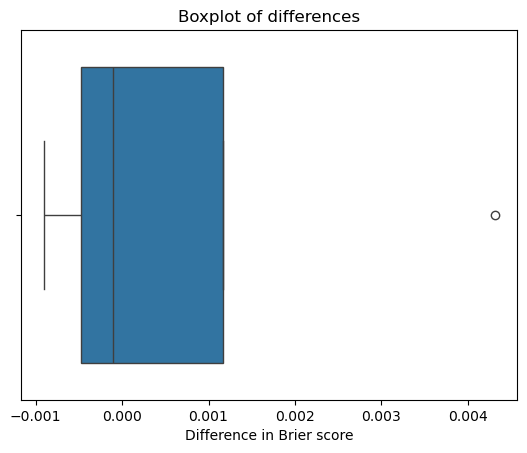

In [28]:
diff = results_df['improvement']

mean_diff = diff.mean()
median_diff = diff.median()
std_diff = diff.std()
epsilon = 0.001 
pct_better = (diff > epsilon).mean() * 100

print(f"Mean difference: {mean_diff:.6f}")
print(f"Median difference: {median_diff:.6f}")
print(f"Std of difference: {std_diff:.6f}")
print(f"Percentage of configurations better than baseline by > {epsilon}: {pct_better:.1f}%")

sns.boxplot(x=diff)
plt.title("Boxplot of differences")
plt.xlabel("Difference in Brier score")
plt.show()

### Analysis of distributions of brier score based on tuning on different dataset sizes

In [29]:
fractions = subsets_df["frac"]
brier_test = subsets_df["brier_test"]

In [30]:
ref_brier = subsets_df.loc[subsets_df['frac']==1.0, 'brier_test'].values[0]
subsets_df['delta_brier'] = subsets_df['brier_test'] - ref_brier
print(subsets_df[['frac', 'delta_brier']])

   frac  delta_brier
0  0.25     0.008518
1  0.50     0.006923
2  0.75     0.006470
3  1.00     0.000000


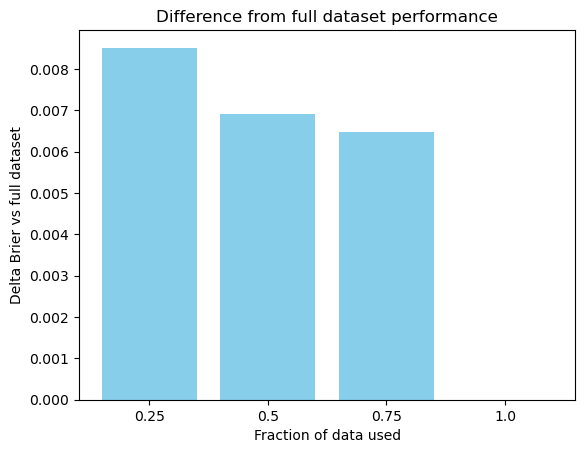

In [31]:
x_labels = subsets_df['frac'].astype(str)

plt.bar(x_labels, subsets_df['delta_brier'], color='skyblue')
plt.xlabel('Fraction of data used')
plt.ylabel('Delta Brier vs full dataset')
plt.title('Difference from full dataset performance')
plt.show()

**On these data less data = worse score. It is something that seems logical**

### Comparison of sampling methods - is there biased sampling?

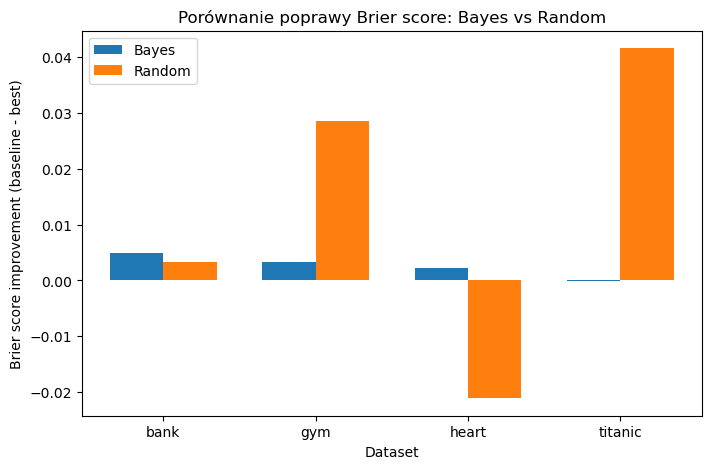

In [32]:
bayes_df['improvement'] = bayes_df['baseline_brier'] - bayes_df['brier_adj']
random_df['improvement'] = random_df['baseline_brier'] - random_df['brier_adj']

plot_df = pd.DataFrame({
    'dataset': bayes_df['dataset'],
    'Bayes': bayes_df['improvement'],
    'Random': random_df['improvement']
})

x = np.arange(len(plot_df['dataset'])) 
width = 0.35 

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x - width/2, plot_df['Bayes'], width, label='Bayes')
ax.bar(x + width/2, plot_df['Random'], width, label='Random')

ax.set_xlabel('Dataset')
ax.set_ylabel('Brier score improvement (baseline - best)')
ax.set_title('Porównanie poprawy Brier score: Bayes vs Random')
ax.set_xticks(x)
ax.set_xticklabels(plot_df['dataset'])
ax.legend()
plt.show()

##### Statistical test to indicate whether there is significant difference between those groups
For all 12 observations - 4 datasets and 3 algorithms make this test

Wilcoxon test:

H0: no difference between methods

H1: there is significant difference between methods

In [33]:
brier_random_svc = [0.1893, 0.1676, 0.1085, 0.1645]

bayes_brier_svc = [0.187609, 0.139217, 0.133284, 0.122124]

brier_random_gbm = [0.18111966687301606, 0.17634326427209, 0.09262259701874374, 0.15942538000177728]

bayes_brier_gbm = [0.18122801197098, 0.17641367844845726, 0.09400881135862903, 0.15707694668742653]

bayes_brier_rf = [0.1845966828222708, 0.178241845238274, 0.1066380630627618, 0.1509247744268588]

random_brier_rf = [0.1847155960056662, 0.1769953375792064, 0.1076035974331696, 0.149755908553256]

In [34]:
all_random = brier_random_gbm + brier_random_svc + random_brier_rf
all_bayes = bayes_brier_gbm + bayes_brier_svc + bayes_brier_rf

In [35]:
stat, p_value = wilcoxon(all_random, all_bayes, method = "exact")
print(f"Wilcoxon statistic: {stat:.4f}, p-value: {p_value:.4f}")

Wilcoxon statistic: 31.0000, p-value: 0.5693


In [36]:
diff = np.array(all_random) - np.array(all_bayes)
print("Średnia różnica (Random - Bayes):", np.mean(diff))

Średnia różnica (Random - Bayes): 0.003926544476772253


### Analysis of convergence speed - comparison of two sampling methods

In [37]:
# Load iteration-by-iteration results for convergence analysis
bayes_full = pd.read_csv('RandomForestData/all_bayesian_results.csv')
random_full = pd.read_csv('RandomForestData/all_randomsearch_results.csv')

In [38]:
def prepare_convergence_data(df, dataset_name, method='bayes'):
    """
    Prepare best-so-far convergence data for a given dataset.
    
    Parameters:
    - df: DataFrame with all results
    - dataset_name: Name of the dataset to filter
    - method: 'bayes' or 'random' to determine column names
    
    Returns:
    - iters: array of iteration numbers
    - brier_per_iter: brier score at each iteration
    - best_so_far: best brier score up to each iteration
    """
    # Filter for this dataset
    ds_data = df[df['dataset'] == dataset_name].copy()
    
    if method == 'bayes':
        # For Bayesian optimization, use trial_number and brier_score
        ds_data = ds_data.sort_values('trial_number')
        iters = ds_data['trial_number'].values
        brier_per_iter = ds_data['brier_score'].values
    else:
        # For Random Search, use rank_test_score (iteration order) and brier_score
        # Note: Random search doesn't have explicit iteration numbers, use index
        ds_data = ds_data.reset_index(drop=True)
        iters = np.arange(len(ds_data))
        brier_per_iter = ds_data['brier_score'].values
    
    # Calculate best-so-far
    best_so_far = np.minimum.accumulate(brier_per_iter)
    
    return iters, brier_per_iter, best_so_far

In [39]:
def chart_best_so_far_comparison(iters_bayes, best_so_far_bayes, iters_random, best_so_far_random, dataset_name):
    """
    Plot comparison of best-so-far convergence for Bayes vs Random search.
    Similar to the chart_best_so_far function in LightGBM.ipynb
    """
    plt.figure(figsize=(10, 5))
   
    plt.plot(iters_bayes, best_so_far_bayes, linewidth=2, label='Best-so-far Bayes', color='blue')
    plt.plot(iters_random, best_so_far_random, linewidth=2, label='Best-so-far Random', color='orange')
    
    plt.xlabel('Iteration')
    plt.ylabel('Brier score (lower is better)')
    plt.title(f'Comparison of best-so-far Brier scores: Bayes vs Random ({dataset_name})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

#### Bank dataset

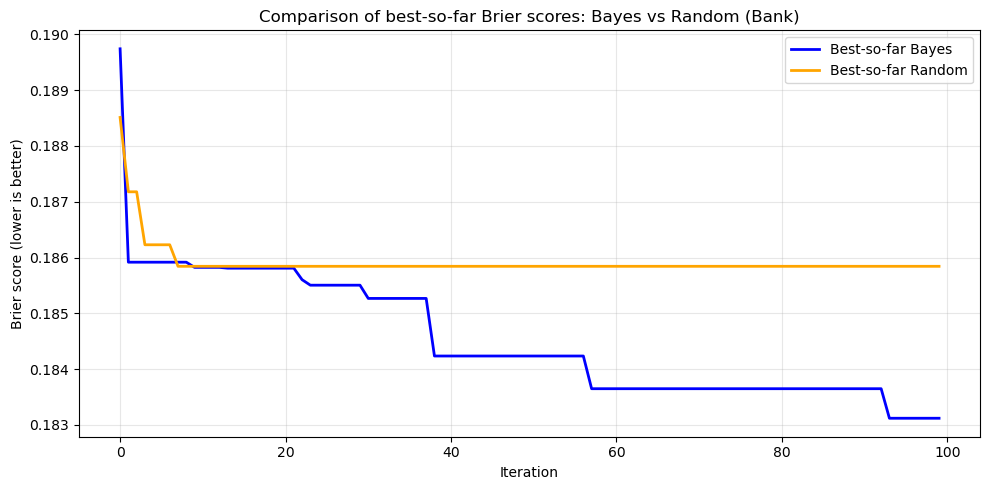

In [40]:
iters_bayes, brier_bayes, best_bayes = prepare_convergence_data(bayes_full, 'Bank', method='bayes')
iters_random, brier_random, best_random = prepare_convergence_data(random_full, 'Bank', method='random')

chart_best_so_far_comparison(iters_bayes, best_bayes, iters_random, best_random, 'Bank')

#### Gym dataset

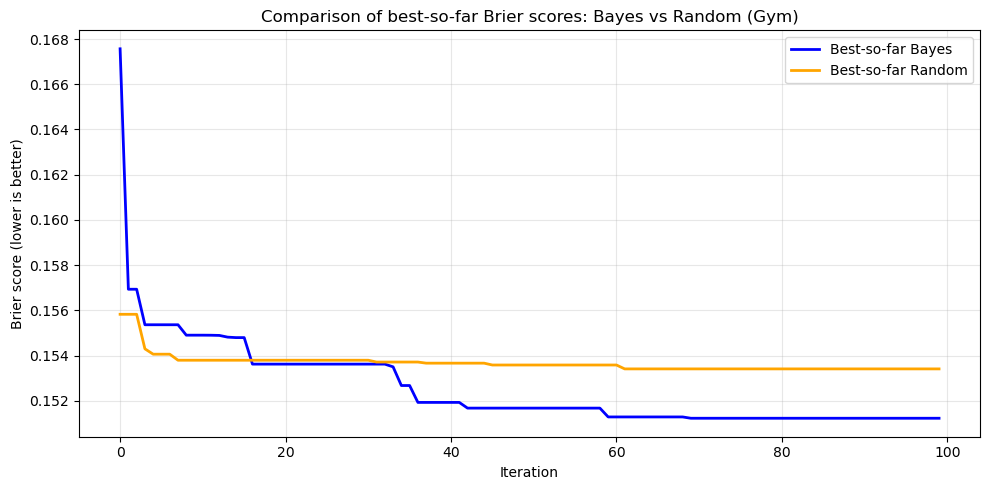

In [41]:
iters_bayes, brier_bayes, best_bayes = prepare_convergence_data(bayes_full, 'Gym', method='bayes')
iters_random, brier_random, best_random = prepare_convergence_data(random_full, 'Gym', method='random')

chart_best_so_far_comparison(iters_bayes, best_bayes, iters_random, best_random, 'Gym')

#### Heart Disease dataset

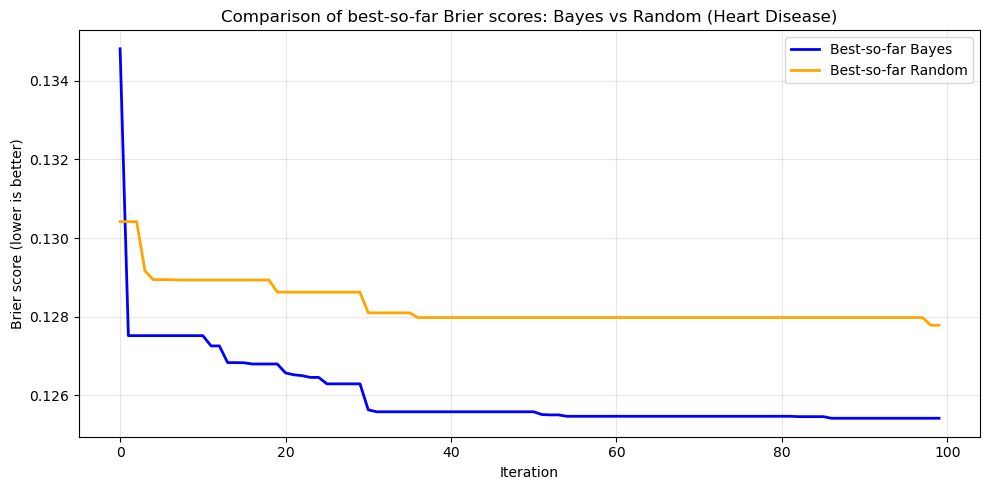

In [42]:
iters_bayes, brier_bayes, best_bayes = prepare_convergence_data(bayes_full, 'Heart Disease', method='bayes')
iters_random, brier_random, best_random = prepare_convergence_data(random_full, 'Heart Disease', method='random')

chart_best_so_far_comparison(iters_bayes, best_bayes, iters_random, best_random, 'Heart Disease')

#### Titanic dataset

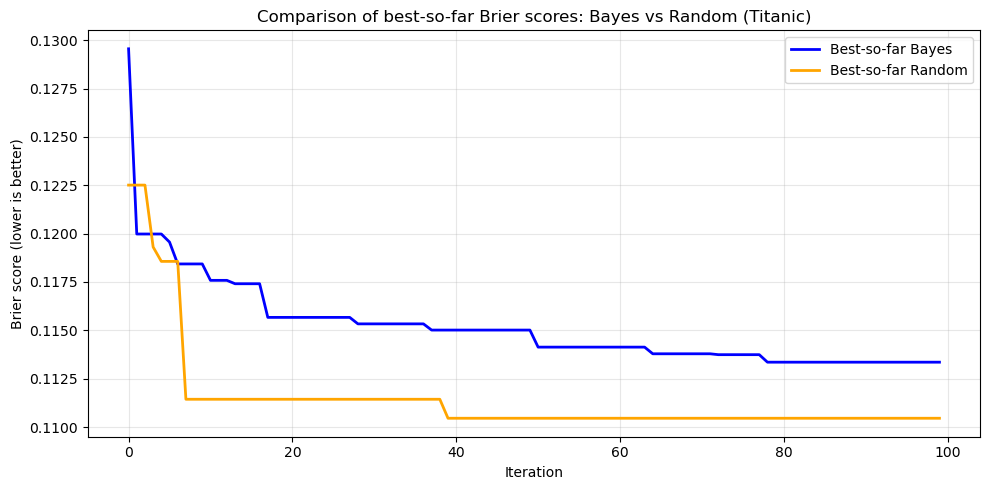

In [43]:
iters_bayes, brier_bayes, best_bayes = prepare_convergence_data(bayes_full, 'Titanic', method='bayes')
iters_random, brier_random, best_random = prepare_convergence_data(random_full, 'Titanic', method='random')

chart_best_so_far_comparison(iters_bayes, best_bayes, iters_random, best_random, 'Titanic')